[View in Colaboratory](https://colab.research.google.com/github/herbiebradley/Tensorflow-Notebooks/blob/master/DCGAN.ipynb)

In [0]:
import tensorflow as tf
import numpy as np
tf.enable_eager_execution()

import os
import time
import numpy as np
import glob
import matplotlib.pyplot as plt
import PIL
from IPython import display

In [0]:
# Test how much GPU RAM on Google Colab
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

In [4]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
# Normalizing the images to the range of [-1, 1]
train_images = (train_images - 127.5) / 127.5

11493376/11490434 [==============================] - 1s 0us/step


In [0]:
BUFFER_SIZE = 60000 # 60000 = number of train mnist images
BATCH_SIZE = 256

In [0]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

### Data input done, now define DCGAN architecture

In [0]:
class Discriminator(tf.keras.Model):
  
  def __init__(self):
    super(Discriminator, self).__init__()
    
    self.conv1 = tf.keras.layers.Conv2D(64, 5, strides=2, input_shape=(28, 28, 1), padding='same')
    self.conv2 = tf.keras.layers.Conv2D(128, 5, strides=2, padding='same')
    self.conv3 = tf.keras.layers.Conv2D(256, 5, strides=2, padding='same')
    self.conv4 = tf.keras.layers.Conv2D(512, 5, strides=1, padding='same')
    
    self.leaky = tf.keras.layers.LeakyReLU(0.3)
    self.dropout = tf.keras.layers.Dropout(0.4)
    self.flatten = tf.keras.layers.Flatten()
    self.fc1 = tf.keras.layers.Dense(1, activation='sigmoid')
    
    
  @tf.contrib.eager.defun  
  def call(self, inputs, training=True):
    x = self.conv1(inputs)
    x = self.leaky(x)
    
    x = self.conv2(x)
    x = self.leaky(x)
    x = self.dropout(x, training=training)
    
    x = self.conv3(x)
    x = self.leaky(x)
    x = self.dropout(x, training=training)
    
    x = self.conv4(x)
    x = self.leaky(x)
    x = self.dropout(x, training=training)
    
    x = self.flatten(x)
    return self.fc1(x)

In [0]:
class Generator(tf.keras.Model):
  
  def __init__(self):
    super(Generator, self).__init__()
    
    self.fc1 = tf.keras.layers.Dense(7*7*256, input_dim=100)
    self.batchnorm1 = tf.keras.layers.BatchNormalization(momentum=0.9)
    
    self.upsample1 = tf.keras.layers.UpSampling2D()
    self.conv1 = tf.keras.layers.Conv2D(128, (5, 5), padding='same')
    self.batchnorm2 = tf.keras.layers.BatchNormalization(momentum=0.9)
                                        
    self.upsample2 = tf.keras.layers.UpSampling2D()
    self.conv2 = tf.keras.layers.Conv2D(64, (5, 5), padding='same')
    self.batchnorm3 = tf.keras.layers.BatchNormalization(momentum=0.9)
    
    self.conv3 = tf.keras.layers.Conv2D(32, (5, 5), padding='same')
    self.batchnorm4 = tf.keras.layers.BatchNormalization(momentum=0.9)
    
    self.conv4 = tf.keras.layers.Conv2D(1, (5, 5), padding='same', activation='sigmoid')
                                        
    self.leaky = tf.keras.layers.LeakyReLU(0.3)
    self.dropout = tf.keras.layers.Dropout(0.4)
    
  @tf.contrib.eager.defun  
  def call(self, inputs, training=True):
    
    x = self.fc1(inputs)
    x = self.batchnorm1(x, training=training)
    x = self.leaky(x)
                                        
    x = tf.reshape(x, shape=(-1, 7, 7, 256))
    x = self.dropout(x, training=training)
    
    x = self.upsample1(x)
    x = self.conv1(x)
    x = self.batchnorm2(x, training=training)
    x = self.leaky(x)
                                        
    x = self.upsample2(x)
    x = self.conv2(x)
    x = self.batchnorm3(x, training=training)
    x = self.leaky(x)
                                        
    x = self.conv3(x)
    x = self.batchnorm4(x, training=training)
    x = self.leaky(x)
                                        
    return self.conv4(x)

In [0]:
generator = Generator()
discriminator = Discriminator()

In [0]:
def discriminator_loss(real_output, generated_output):
    # [1,1,...,1] with real output since it is true and we want
    # our generated examples to look like it
    # Don't need to use tf.reduce_mean because using Eager training
    real_loss = tf.losses.sigmoid_cross_entropy(multi_class_labels=tf.ones_like(real_output), logits=real_output)

    # [0,0,...,0] with generated images since they are fake
    generated_loss = tf.losses.sigmoid_cross_entropy(multi_class_labels=tf.zeros_like(generated_output), logits=generated_output)

    total_loss = real_loss + generated_loss

    return total_loss

In [0]:
def generator_loss(generated_output):
    return tf.losses.sigmoid_cross_entropy(tf.ones_like(generated_output), generated_output)

In [0]:
discriminator_optimizer = tf.train.AdamOptimizer(0.0004)
generator_optimizer = tf.train.AdamOptimizer(0.0004)

In [0]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [0]:
EPOCHS = 1
noise_dim = 100
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement of the gan.
random_vector_for_generation = tf.random_normal([num_examples_to_generate,
                                                 noise_dim])

In [0]:
def generate_and_save_images(model, epoch, test_input):
  # make sure the training parameter is set to False because
  # don't want to train the batchnorm layer when doing inference.
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))
  
  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')
        
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [0]:
def train(dataset, epochs, noise_dim):  
  for epoch in range(epochs):
    start = time.time()
    
    for images in dataset:
      # generating noise from a uniform distribution
      noise = tf.random_normal([BATCH_SIZE, noise_dim])
      
      with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
      
        real_output = discriminator(images, training=True)
        generated_output = discriminator(generated_images, training=True)
        
        gen_loss = generator_loss(generated_output)
        disc_loss = discriminator_loss(real_output, generated_output)
        
      gradients_of_generator = gen_tape.gradient(gen_loss, generator.variables)
      gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.variables)
      
      generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.variables))
      discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.variables))

      
    generate_and_save_images(generator, epoch + 1, random_vector_for_generation)
    
    # saving (checkpoint) the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
    
    print ('Time taken for epoch {} is {} sec'.format(epoch + 1,
                                                      time.time()-start))
  # generating after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           random_vector_for_generation)

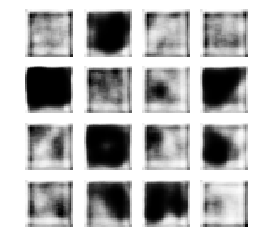

In [43]:
train(train_dataset, EPOCHS, noise_dim)